### About
This notebook contains simple, toy examples to help you get started with FairMLHealth tool usage. This same content is mirrored in the repository's main [README](../../../README.md)

### Example Setup

In [1]:
from fairmlhealth import model_comparison as fhmc, reports


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor
np.random.seed(547)

# Load data
X = pd.DataFrame({'col1': np.random.randint(1, 50, 32), 
                  'col2': np.random.randint(1, 50, 32),
                  'col3': np.random.randint(1, 50, 32),
                  'gender': [0, 1]*16, 
                  'ethnicity': [1, 1, 0, 0]*8,
                  'other': [1, 0, 0, 1]*8
                 })

y = pd.Series(np.random.uniform(0, 8, 32), index=X.index, name="y")
X_train, y_train= X.iloc[0:8], y.iloc[0:8]
X_test, y_test = X.iloc[8:32], y.iloc[8:32]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=36)

#Train models
model_1 = LinearRegression().fit(X_train, y_train)
model_2 = TweedieRegressor().fit(X_train, y_train)

# Deterimine your set of protected attributes
prtc_attr = X_test['gender']

# Specify either a dict or a list of trained models to compare
model_dict = {'model_1': model_1, 'model_2': model_2}


In [2]:
display(X.head())

,col1,col2,col3,gender,ethnicity,other
0,48,20,16,0,1,1
1,24,44,2,1,1,0
2,19,44,42,0,0,0
3,38,49,44,1,0,1
4,45,23,19,0,1,1


### Model Measurement
The primary feature of this library is the model comparison tool. The current version supports assessment of binary prediction models through use of the measure_models and compare_models functions.

Measure_model is designed to generate a report of multiple fairness metrics for a single model. Here it is shown wrapped in a "flag" function to emphasize values that are outside of the "fair" range. 

In [3]:
# Generate a pandas dataframe of measures
fhmc.measure_model(X_test, y_test, prtc_attr, model_1, pred_type="regression")


~/repos/fairMLHealth/fairmlhealth/model_comparison.py:262: UserWarning: Please note that probabilities could not be generated for the following models: ['model 1']. Dependent metrics will be skipped.
  "Dependent metrics will be skipped.")


Value
Group Fairness                   Mean Prediction Ratio                0.2463
                                 MAE Ratio                            1.5217
                                 Mean Prediction Difference          -2.0976
                                 MAE Difference                       1.4295
Individual Fairness              Consistency Score                   -0.1272
                                 Between-Group Gen. Entropy Error     0.0000
Model Performance (Weighted Avg) Target Mean                          3.6827
                                 Pred. Mean                           1.7342
                                 MSE                                 17.3016
                                 MAE                                  3.4547
Data Metrics                     Prevalence of Privileged Class (%)   0.0000

### Evaluating

FairMLHealth now also includes stratified reporting features to aid in identifying the source of unfairness or other bias: data reports, performance reports, and bias reports. Note that these stratified reports can evaluate multiple features at once, and that there are two options for identifying which features to assess.

Note that the flag tool has not yet been updated to work with stratified reports.

#### Stratified Data Reports

The data reporter is shown below with each of the two data argument options. It evaluates basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since the reporter can evaluate many features at once, it can be a useful option for identifying patterns of bias either alone or in concert with other (e.g., visual methods).

In [4]:
# Arguments Option 1: pass full set of data, subsetting with *features* argument
reports.data_report(X_test, y_test, features=['gender'])

USER ALERT! The following features have more than 11 values, which will slow processing time. Consider reducing to bins or quantiles: ['y']


,Feature Name,Feature Value,Obs.,Entropy,Missing Values,Value Prevalence,y Mean,y Median,y Std. Dev.
0,ALL FEATURES,ALL VALUES,24,NaN,0,1.0,3.6827,3.5202,2.2907
1,gender,0,12,1.0,0,0.5,4.8548,4.7284,1.9515
2,gender,1,12,1.0,0,0.5,2.5105,1.6521,2.0409


#### Stratified Performance Reports

The stratified perofrmance reporter evaluates model performance specific to each feature-value subset. If prediction probabilities are available to the model, additional ROC AUC and PR AUC values will be included.

In [5]:
reports.performance_report(X_test[['gender']], y_test, 
                           model_1.predict(X_test), pred_type="regression")

,Feature Name,Feature Value,Obs.,Target Mean,Pred. Mean,Error Mean,Error Std. Dev.,MAE,MSE,Pred. Median,Pred. Std. Dev.
0,ALL FEATURES,ALL VALUES,24.0,3.6827,1.7342,-1.9485,3.7540,3.4547,17.3016,1.5364,2.7788
1,gender,0,12.0,4.8548,0.6854,-4.1695,2.5220,4.1695,23.2149,0.4987,2.5629
2,gender,1,12.0,2.5105,2.7830,0.2725,3.5132,2.7400,11.3883,1.6257,2.6789


#### Stratified Bias Reports

The stratified bias reporter presents model bias specific to each feature-value subset. Inspired by common measures of fairness, the reporter assumes each feature-value as the "privileged" group relative to all other possible values for the feature. For example, row 3 in the table below displaying measures of "col1" value of "2" where 2 is considered to be the privileged group and all other values (1, 2, 45, and 50) are considered unprivileged.

To simplify the report, fairness measures have been simplified to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

See also: [Fairness Quick References](../docs/Fairness_Quick_References.pdf) and the [Tutorial for Evaluating Fairness in Binary Classification](./Tutorial-EvaluatingFairnessInBinaryClassification.ipynb)

In [6]:
reports.bias_report(X_test[['gender', 'col2']], y_test, 
                    model_1.predict(X_test), pred_type="regression")

USER ALERT! The following features have more than 11 values, which will slow processing time. Consider reducing to bins or quantiles: ['col2']


~/repos/fairMLHealth/fairmlhealth/utils.py:63: UserWarning: Error processing column(s) ['col2']. R Squared Score result out of range (-0.6897921524780235)

  warn(f"Error processing column(s) {cols}. {er}\n")
~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['col2']. R^2 score is not well-defined with less than two samples.

  warn(f"Possible error in column(s) {cols}. {wr}\n")


,Feature Name,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio,R2 Difference,R2 Ratio
0,gender,-1.4295,0.6572,2.0976,4.0606,NaN,NaN
1,gender,1.4295,1.5217,-2.0976,0.2463,NaN,NaN
2,col2,-1.4943,0.6903,0.0724,1.0434,NaN,NaN
3,col2,1.6877,1.8847,-0.1697,0.9102,NaN,NaN
4,col2,2.0142,2.3212,0.0748,1.0450,NaN,NaN
5,col2,0.2368,1.0734,2.3153,-3.7771,NaN,NaN
6,col2,-4.5541,0.4176,5.0743,-0.6219,NaN,NaN
7,col2,-1.8619,0.6446,-1.0440,0.6182,NaN,NaN
8,col2,2.9588,5.7785,0.0525,1.0312,NaN,NaN
9,col2,-3.2700,0.5037,4.1458,-0.8517,NaN,NaN


## Special Cases

### Hypothetical Example for which Only Mid-Range Values Need Be Accurate

Patients undergoing a multi-stage surgical procedure, the treatment times for which are predicted by a machine learning model.

| Average Predicted Time in Surgery | Intervention |
| - | - |
|0-5 hours | Outpatient Procedures |
|5-9 hours | Treatment Decision Depends on Predicted Trends in Surgery Time |
| 9+ hours | Inpatient Procedures |

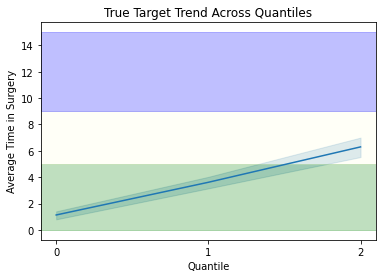

In [7]:
# Generate quantiles
quantiles = pd.qcut(y_test, 3, labels=False)

# Generate plots
g = sns.lineplot(x=quantiles, y=y_test)
g.axhspan(0, 5, alpha=0.25, color='green')
g.axhspan(5, 9, alpha=0.25, color='lightyellow')
g.axhspan(9, 15, alpha=0.25, color='blue')
plt.xticks([*range(3)], [*range(3)])
g.set_xlabel("Quantile")
g.set_ylabel("Average Time in Surgery")
g.set_title("True Target Trend Across Quantiles")
plt.show()


## Cohort Analysis

In [8]:
reports.bias_report(X_test[['gender', 'col2']], y_test, model_1.predict(X_test), 
                    pred_type="regression", cohorts=quantiles)

~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['gender']. R^2 score is not well-defined with less than two samples.

  warn(f"Possible error in column(s) {cols}. {wr}\n")
~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['col2']. R^2 score is not well-defined with less than two samples.

  warn(f"Possible error in column(s) {cols}. {wr}\n")
~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['col2']. R^2 score is not well-defined with less than two samples.

  warn(f"Possible error in column(s) {cols}. {wr}\n")
~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['gender']. R^2 score is not well-defined with less than two samples.

  warn(f"Possible error in column(s) {cols}. {wr}\n")
~/repos/fairMLHealth/fairmlhealth/utils.py:67: UserWarning: Possible error in column(s) ['col2']. R^2 score is not well-defined with less than two sampl

,Feature Name,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio,R2 Difference,R2 Ratio
y,,,,,,,
0,gender,2.0447,6.1223,2.1714,3.7605,NaN,NaN
0,gender,-2.0447,0.1633,-2.1714,0.2659,NaN,NaN
0,col2,0.1773,1.0872,3.9503,-4.1303,NaN,NaN
0,col2,0.7587,1.4976,1.1703,1.7039,NaN,NaN
0,col2,1.7933,3.8961,1.1459,1.6805,NaN,NaN
0,col2,-5.2882,0.2241,-5.8218,0.2518,NaN,NaN
0,col2,-0.3593,0.8564,-1.8149,0.5754,NaN,NaN
0,col2,2.3771,22.9372,1.8842,2.8154,NaN,NaN
0,col2,2.0447,6.1223,2.1714,3.7605,NaN,NaN
